In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
# Fetch data from Yahoo Finance
ticker = "ZOMATO.NS"
start_date = "2021-08-01"
end_date = "2024-01-31"
data = yf.download(ticker, start=start_date, end=end_date)

data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-08-02,135.750000,140.750000,135.149994,139.699997,139.699997,66909732
2021-08-03,137.000000,140.800003,137.000000,139.399994,139.399994,46610001
2021-08-04,139.800003,141.000000,135.250000,138.399994,138.399994,41134419
2021-08-05,138.750000,138.899994,132.000000,134.949997,134.949997,38437134
2021-08-06,135.500000,136.199997,130.100006,131.350006,131.350006,31975356
...,...,...,...,...,...,...
2024-01-23,136.300003,137.300003,127.000000,130.100006,130.100006,72520625
2024-01-24,131.449997,136.899994,129.800003,136.199997,136.199997,54612769
2024-01-25,135.899994,138.199997,132.800003,136.149994,136.149994,60682540


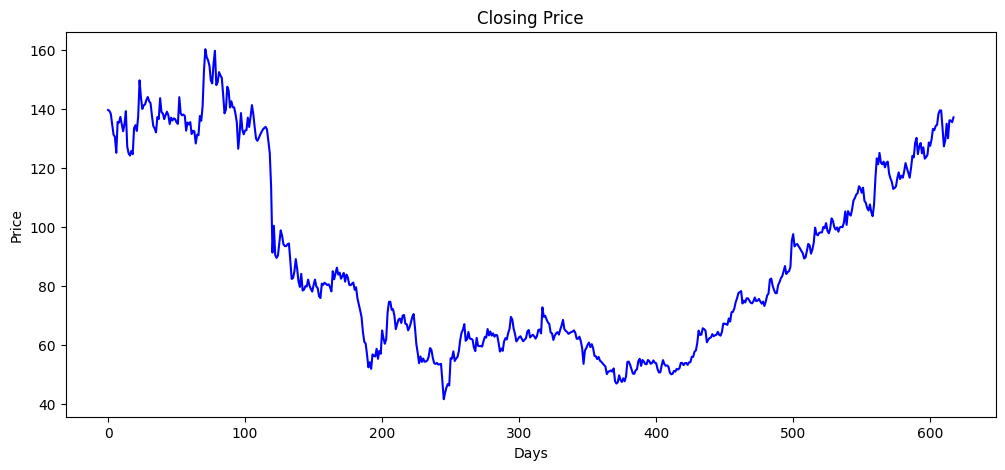

In [3]:
# Plot closing price
close_prices = data[['Close']].values
plt.figure(figsize=(12,5))
plt.plot(close_prices, color='blue')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Closing Price')
plt.show()

In [4]:
# Preprocessing
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
scaled_data = torch.FloatTensor(scaled_data).view(-1)

scaled_data

tensor([ 0.6528,  0.6477,  0.6308,  0.5727,  0.5120,  0.4994,  0.4083,  0.5845,
         0.5811,  0.6131,  0.5727,  0.5314,  0.5727,  0.6460,  0.4429,  0.4050,
         0.3923,  0.4193,  0.3999,  0.5491,  0.5660,  0.5331,  0.6174,  0.8222,
         0.7261,  0.6587,  0.6789,  0.6848,  0.7109,  0.7269,  0.7025,  0.6924,
         0.6224,  0.5617,  0.5474,  0.5247,  0.6123,  0.6013,  0.7202,  0.6410,
         0.6325,  0.6005,  0.6241,  0.6426,  0.6233,  0.5727,  0.6089,  0.5929,
         0.6047,  0.6005,  0.5811,  0.5735,  0.7261,  0.6334,  0.6224,  0.6266,
         0.6199,  0.5348,  0.5811,  0.5702,  0.5836,  0.5154,  0.5339,  0.5306,
         0.4614,  0.5120,  0.5086,  0.6182,  0.5912,  0.6730,  0.8769,  1.0000,
         0.9545,  0.9368,  0.9056,  0.8222,  0.8045,  0.9191,  0.9907,  0.7952,
         0.8112,  0.8694,  0.8500,  0.8373,  0.7404,  0.6334,  0.6544,  0.7859,
         0.7632,  0.6671,  0.7025,  0.6688,  0.6679,  0.6308,  0.5794,  0.4311,
         0.5162,  0.6351,  0.5398,  0.51

In [5]:
# Function to create sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i+seq_length]
        target = data[i+seq_length:i+seq_length+1]
        sequences.append((sequence, target))
    return sequences

In [6]:
# Definition the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [7]:
# Initialize the model
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Training the model
epochs = 100
seq_length = 10

for i in range(epochs):
    for seq, labels in create_sequences(scaled_data, seq_length):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%10 == 0:
        print(f'Epoch {i} Loss: {single_loss.item()}')

Epoch 0 Loss: 0.01658298633992672
Epoch 10 Loss: 0.00012543222692329437
Epoch 20 Loss: 0.0009440880385227501
Epoch 30 Loss: 0.00042170059168711305
Epoch 40 Loss: 0.0007296766270883381
Epoch 50 Loss: 0.0016420597676187754
Epoch 60 Loss: 0.001871337997727096
Epoch 70 Loss: 0.0006059739971533418
Epoch 80 Loss: 0.0005672524566762149
Epoch 90 Loss: 0.0002636234275996685


In [9]:
# Making predictions
future = 30
preds = scaled_data[-seq_length:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-seq_length:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        preds.append(model(seq).item())

In [10]:
# Inverse scaling
true_predictions = scaler.inverse_transform(np.array(preds[seq_length:]).reshape(-1, 1))

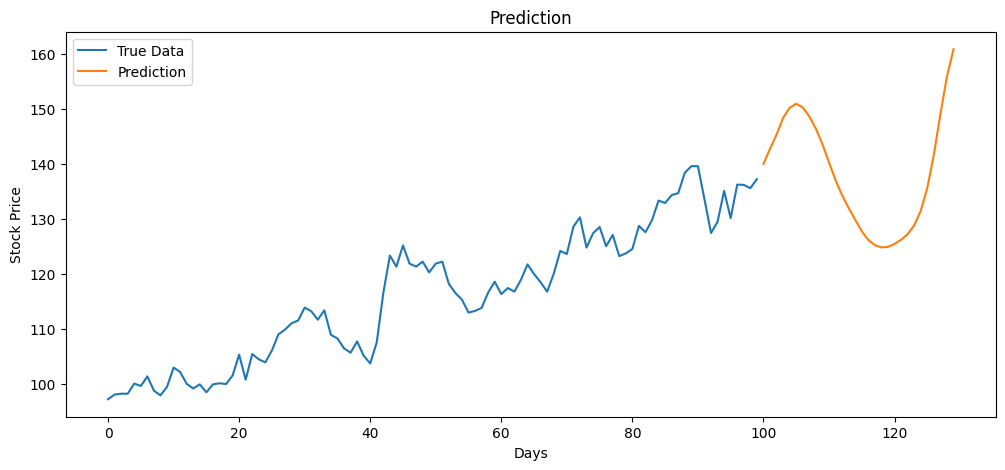

In [11]:
# Plotting the results
last_100_days_data = data['Close'].values[-100:]
last_100_days_true = true_predictions[-100:]

plt.figure(figsize=(12, 5))
plt.title('Prediction')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.plot(last_100_days_data, label='True Data')
plt.plot(range(100, 130), last_100_days_true, label='Prediction')
plt.legend()
plt.show()